In [ ]:
########CELLA 1###############
from google.colab import drive
import zipfile
import os

# 1. Monta Google Drive
drive.mount('/content/drive')

# 2. Configurazione Percorsi
# Assumiamo che il file sia nella root del tuo Drive.
# Se è in una sottocartella, modifica in: '/content/drive/MyDrive/NOME_CARTELLA/dataset.zip'
zip_path = '/content/drive/MyDrive/dataset.zip'
extract_to = '/content/dataset_unzipped'

# 3. Estrazione
if os.path.exists(zip_path):
    print(f"Trovato {zip_path}. Inizio estrazione...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("✅ Estrazione completata!")
else:
    print(f"❌ ERRORE: Non trovo il file '{zip_path}'.")
    print("Controlla di averlo caricato su Drive e che il nome sia esattamente 'dataset.zip' (tutto minuscolo).")

Mounted at /content/drive
Trovato /content/drive/MyDrive/dataset.zip. Inizio estrazione...
✅ Estrazione completata!


In [ ]:
############CELLA 2#################
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class BookCoverDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, class_to_idx=None):
        """
        Args:
            csv_file (string): Percorso al file CSV.
            root_dir (string): Directory che contiene le immagini (224x224).
            transform (callable, optional): Trasformazioni (Tensor, Normalize).
        """
        # Lettura CSV con i parametri corretti scoperti prima (sep=; encoding=ISO...)
        self.df = pd.read_csv(csv_file, sep=';', encoding='ISO-8859-1', header=0, on_bad_lines='warn')

        self.root_dir = root_dir
        self.transform = transform

        # Ordina le classi per garantire coerenza
        self.classes = sorted(self.df['Category'].unique())

        # Mappa Stringa -> Intero
        if class_to_idx is None:
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        else:
            self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Recupera nome file e costruisce percorso
        img_name = str(self.df.iloc[idx]['Filename'])
        img_path = os.path.join(self.root_dir, img_name)

        # Caricamento Immagine
        try:
            image = Image.open(img_path).convert('RGB')
        except (OSError, FileNotFoundError):
            # Gestione immagine mancante (crea immagine nera)
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        # Label
        label_str = self.df.iloc[idx]['Category']
        label = self.class_to_idx[label_str]

        # Trasformazioni
        if self.transform:
            image = self.transform(image)

        return image, label

# --- CONFIGURAZIONE TRASFORMAZIONI ---
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        # 1. RandomResizedCrop: Taglia pezzi casuali e li riporta a 224x224.
        # Costringe la rete a guardare i dettagli. scale=(0.8, 1.0) significa che prende almeno l'80% dell'immagine.
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),

        transforms.RandomHorizontalFlip(),

        # 2. ColorJitter: Variazione di luminosità e contrasto (fondamentale per scansioni diverse)
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),

        transforms.RandomRotation(15),

        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)), # Nel validation NON facciamo augmentation
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [ ]:
#################CELLA 3####################
# Cerchiamo i percorsi corretti navigando tra le cartelle estratte
base_search_path = '/content/dataset_unzipped'
csv_path = None
img_dir = None

print("🔍 Scansione cartelle in corso...")

for root, dirs, files in os.walk(base_search_path):
    # Cerchiamo il CSV di training
    if "book30-listing-train.csv" in files:
        csv_path = os.path.join(root, "book30-listing-train.csv")
        print(f"   -> CSV Trovato: {csv_path}")

    # Cerchiamo la cartella specifica delle immagini
    if "224x224" in dirs:
        img_dir = os.path.join(root, "224x224")
        print(f"   -> Cartella Immagini Trovata: {img_dir}")

# --- VERIFICA E CREAZIONE DATASET ---
if csv_path and img_dir:
    print("\n✅ File trovati! Creazione Dataset in corso...")

    # Creiamo il dataset
    train_dataset = BookCoverDataset(
        csv_file=csv_path,
        root_dir=img_dir,
        transform=data_transforms['train']
    )

    # TEST RAPIDO
    print(f"Dataset caricato correttamente con {len(train_dataset)} libri.")
    print(f"Numero di classi (Generi): {len(train_dataset.classes)}")

    # Verifica GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n🖥️ Device attivo: {device}")
    if device.type == 'cuda':
        print("🚀 Perfetto! La GPU NVIDIA T4 è pronta a spingere.")
    else:
        print("⚠️ ATTENZIONE: Stai usando la CPU. Vai su Modifica -> Impostazioni Notebook -> Hardware Accelerator -> T4 GPU")

    # Test estrazione di un elemento
    img, label = train_dataset[0]
    print(f"\nTest Shape Tensore: {img.shape} (Deve essere 3, 224, 224)")

else:
    print("\n❌ ERRORE CRITICO: Non ho trovato i file necessari.")
    print("Controlla il contenuto dello zip. Cerco 'book30-listing-train.csv' e una cartella '224x224'.")

🔍 Scansione cartelle in corso...
   -> CSV Trovato: /content/dataset_unzipped/dataset/book30-listing-train.csv
   -> Cartella Immagini Trovata: /content/dataset_unzipped/dataset/title30cat/224x224

✅ File trovati! Creazione Dataset in corso...
Dataset caricato correttamente con 51300 libri.
Numero di classi (Generi): 30

🖥️ Device attivo: cuda
🚀 Perfetto! La GPU NVIDIA T4 è pronta a spingere.

Test Shape Tensore: torch.Size([3, 224, 224]) (Deve essere 3, 224, 224)


In [ ]:
###############CELLA 4##############
from torch.utils.data import DataLoader, random_split

# 1. Divisione Train / Validation (80% / 20%)
total_size = len(train_dataset)
train_len = int(0.8 * total_size)
val_len = total_size - train_len

# random_split mischia gli indici e crea due sotto-dataset
train_subset, val_subset = random_split(train_dataset, [train_len, val_len])

print(f"📊 Split completato:")
print(f"   -> Training Set: {len(train_subset)} immagini")
print(f"   -> Validation Set: {len(val_subset)} immagini")

# 2. Creazione dei DataLoader (I 'nastri trasportatori' per la GPU)
# Batch Size 64 è ottimale per la GPU T4 di Colab (usa bene la memoria senza esaurirla)
BATCH_SIZE = 128

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✅ Dataloaders pronti (Batch size: {BATCH_SIZE})")

📊 Split completato:
   -> Training Set: 41040 immagini
   -> Validation Set: 10260 immagini
✅ Dataloaders pronti (Batch size: 128)


In [ ]:
###############CELLA 5###################
from torchvision import models
import torch.nn as nn

def get_model(num_classes=30):
    print("Scaricamento pesi ResNet50 (ImageNet)...")
    # Scarichiamo la versione più aggiornata dei pesi
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # 1. FREEZING: Congeliamo tutti i parametri
    # Questo impedisce che durante il training modifichiamo i filtri che sanno già "vedere"
    for param in model.parameters():
        param.requires_grad = False

    # 2. Sostituzione dell'ultimo layer (Fully Connected)
    # ResNet50 ha 2048 feature in ingresso all'ultimo layer
    num_ftrs = model.fc.in_features

    # Creiamo il nuovo layer classificatore.
    # Nota: Di default, i nuovi layer hanno requires_grad=True, quindi QUESTI verranno addestrati.
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512), # Strato intermedio per imparare combinazioni complesse
        nn.ReLU(),
        nn.Dropout(0.5),          # Dropout per evitare overfitting (tecnica standard)
        nn.Linear(512, num_classes) # Output finale: 30 probabilità
    )

    return model

# Istanziamo il modello e lo spostiamo sulla GPU
model = get_model(num_classes=len(train_dataset.classes))
model = model.to(device) # Sposta tutto sulla GPU T4

print("\n🤖 Modello ResNet50 caricato e modificato per 30 classi.")
print("   -> Backbone (corpo): Congelato ❄️")
print("   -> Head (testa): Pronta per l'addestramento 🔥")

Scaricamento pesi ResNet50 (ImageNet)...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 124MB/s]



🤖 Modello ResNet50 caricato e modificato per 30 classi.
   -> Backbone (corpo): Congelato ❄️
   -> Head (testa): Pronta per l'addestramento 🔥


In [6]:
##################CELLA 6#################
import torch.optim as optim
import time
import torch.nn as nn

# --- 1. CONFIGURAZIONE SCONGELAMENTO SELETTIVO ---
print("🔒 Congelamento preventivo di tutta la rete...")
for param in model.parameters():
    param.requires_grad = False

print("🔓 Scongelamento della Testa (FC) e dell'Ultimo Blocco (Layer4)...")
# Scongeliamo la testa (il tuo classificatore personalizzato)
for param in model.fc.parameters():
    param.requires_grad = True

# Scongeliamo l'ultimo blocco del backbone (ResNet50: layer4)
# Questo permette alla rete di adattare le feature di alto livello ai libri
for param in model.layer4.parameters():
    param.requires_grad = True

# Raccogliamo tutti i parametri che richiedono gradiente (Head + Layer4)
params_to_update = [p for p in model.parameters() if p.requires_grad]


# --- 2. CONFIGURAZIONE TRAINING ---
# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
# IMPORTANTE: Ora passiamo 'params_to_update' che include sia FC che Layer4
# Nota: 0.001 è un LR standard, ma se noti instabilità (loss che salta),
# prova ad abbassarlo a 1e-4 (0.0001) dato che stiamo toccando il backbone.
optimizer = optim.Adam(params_to_update, lr=0.001)

# Numero di Epoche
NUM_EPOCHS = 5


# --- 3. FUNZIONE DI TRAINING (Invariata) ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Ogni epoca ha una fase di training e una di validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Mette il modello in modalità addestramento
                dataloader = train_loader
            else:
                model.eval()   # Mette il modello in modalità valutazione
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            # Iterazione sui batch
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Azzera i gradienti
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + Optimize solo in training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistiche
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    time_elapsed = time.time() - start_time
    print(f'\nAddestramento completato in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    return model

# --- AVVIO TRAINING ---
print("🚀 Inizio Addestramento (Head + Layer4)...")
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS)

🔒 Congelamento preventivo di tutta la rete...
🔓 Scongelamento della Testa (FC) e dell'Ultimo Blocco (Layer4)...
🚀 Inizio Addestramento (Head + Layer4)...

Epoch 1/5
----------
train Loss: 2.7767 Acc: 0.2259
val Loss: 2.6060 Acc: 0.2633

Epoch 2/5
----------
train Loss: 2.4934 Acc: 0.2996
val Loss: 2.4910 Acc: 0.2955

Epoch 3/5
----------
train Loss: 2.3346 Acc: 0.3358
val Loss: 2.4555 Acc: 0.3046

Epoch 4/5
----------
train Loss: 2.1934 Acc: 0.3696
val Loss: 2.4954 Acc: 0.3046

Epoch 5/5
----------
train Loss: 2.0493 Acc: 0.4063
val Loss: 2.5098 Acc: 0.3104

Addestramento completato in 26m 30s


In [7]:
############CELLA 6.5###########
#salvataggio modello addestrato su drive
import os
import torch

# Cartella su Drive dove salvare il modello
save_dir = "/content/drive/MyDrive/bookcover_models"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "resnet50_bookcovers.pth")

# Creiamo un dizionario con tutto ciò che ci serve in futuro
checkpoint = {
    "model_state_dict": trained_model.state_dict(),      # pesi del modello
    "class_to_idx": train_dataset.class_to_idx,          # mappa "nome_genere -> indice"
    "classes": train_dataset.classes,                    # lista ordinata dei generi
}

torch.save(checkpoint, model_path)

print(f"✅ Modello salvato in: {model_path}")
print("   Puoi ora ricaricarlo in un altro notebook senza rifare il training.")


✅ Modello salvato in: /content/drive/MyDrive/bookcover_models/resnet50_bookcovers.pth
   Puoi ora ricaricarlo in un altro notebook senza rifare il training.


Generazione grafico in corso...
📊 Calcolo delle predizioni sul Validation Set...


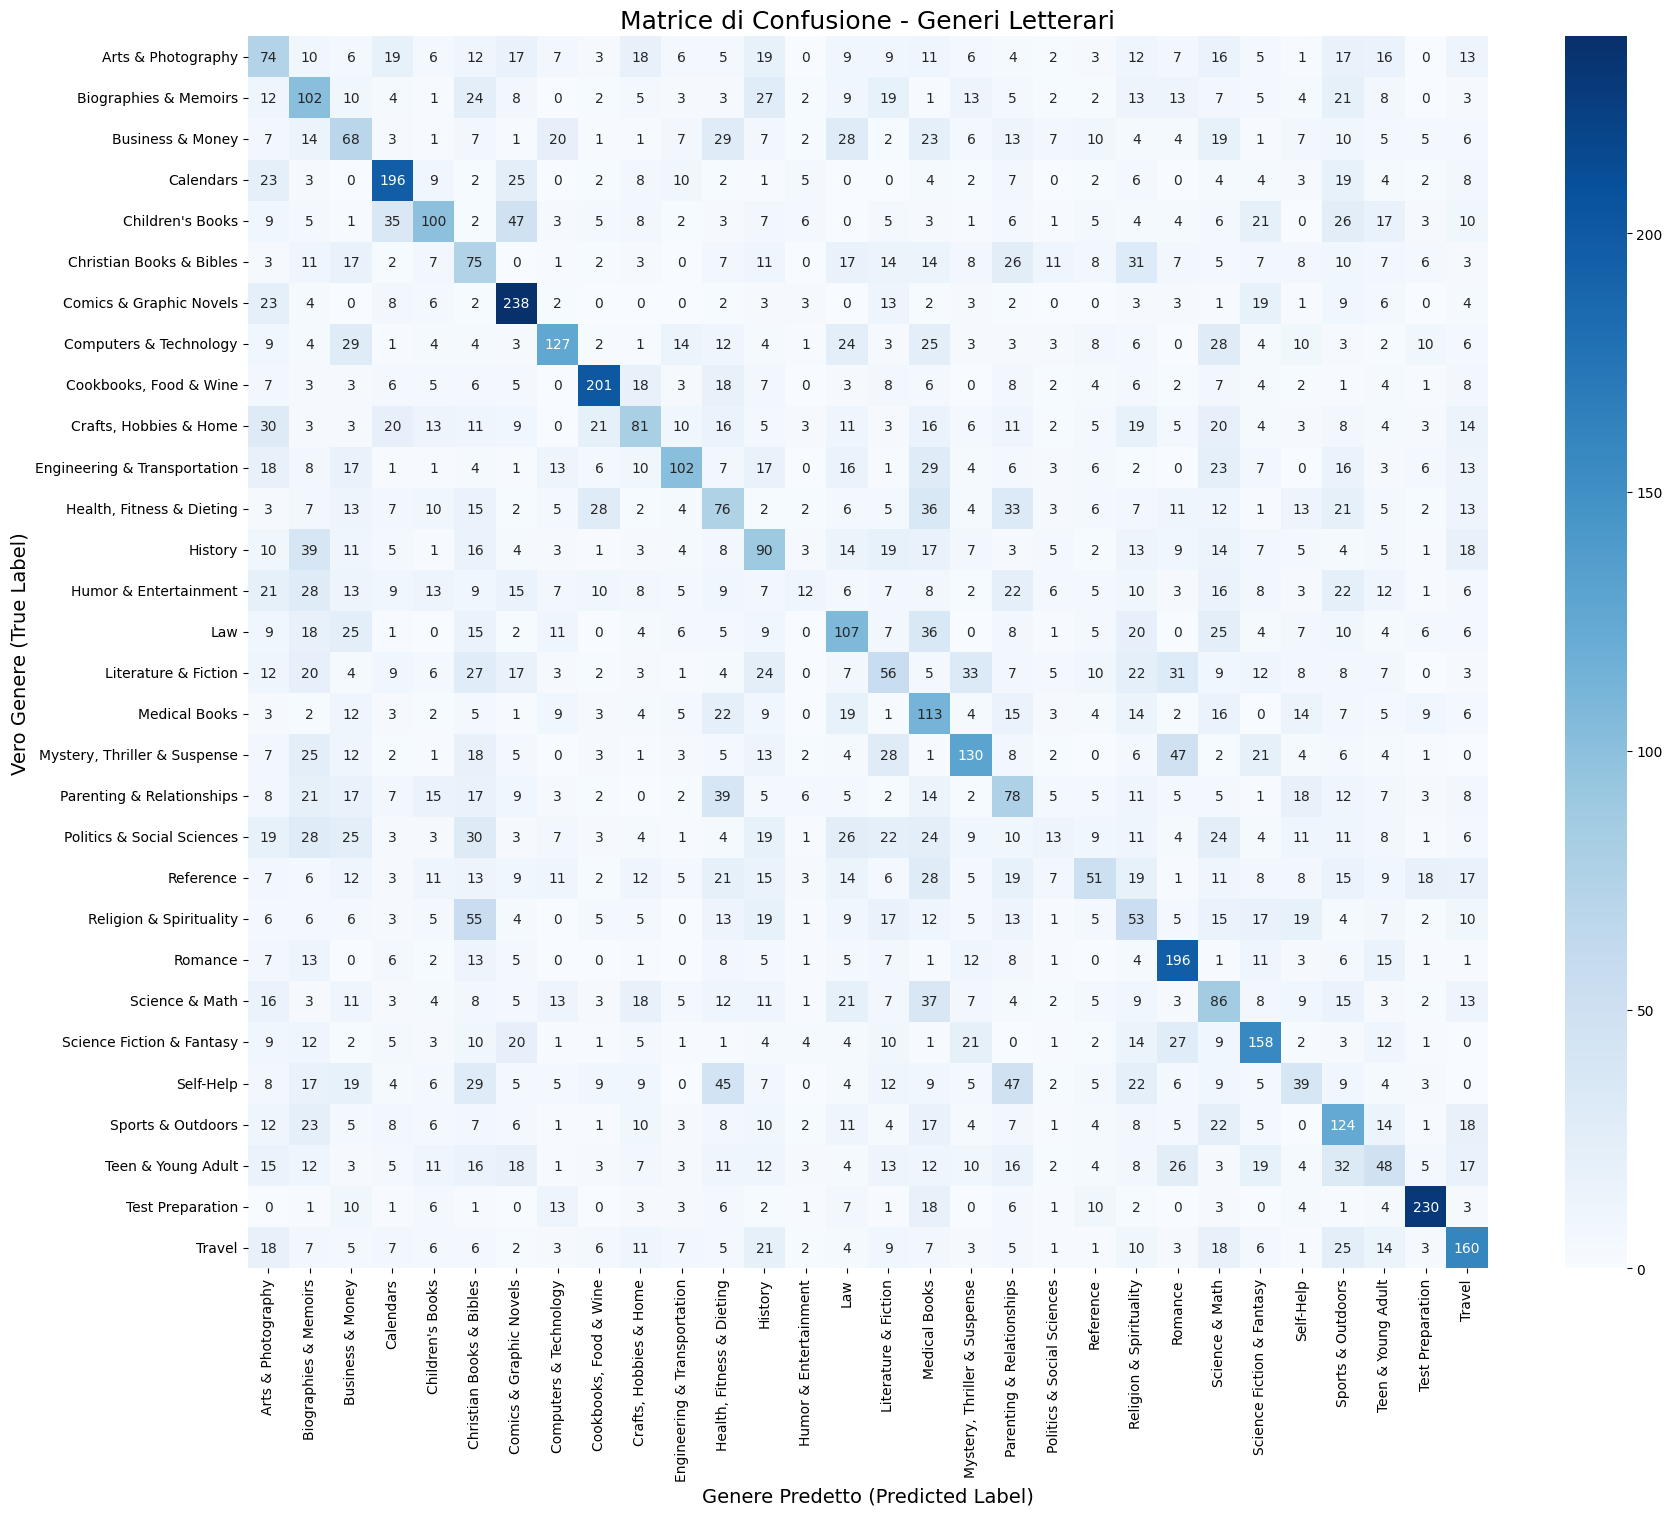

In [8]:
##################CELLA 7#################
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(model, dataloader, classes):
    model.eval() # Modalità valutazione
    y_true = []
    y_pred = []

    print("📊 Calcolo delle predizioni sul Validation Set...")
    with torch.no_grad(): # Disabilita il calcolo dei gradienti (risparmia memoria)
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Spostiamo su CPU e convertiamo in numpy
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calcolo della matrice
    cm = confusion_matrix(y_true, y_pred)

    # Normalizzazione (opzionale, per vedere le % invece dei numeri assoluti)
    # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plotting
    plt.figure(figsize=(20, 16)) # Dimensioni grandi per farci stare 30 classi
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)

    plt.ylabel('Vero Genere (True Label)', fontsize=14)
    plt.xlabel('Genere Predetto (Predicted Label)', fontsize=14)
    plt.title('Matrice di Confusione - Generi Letterari', fontsize=18)
    plt.xticks(rotation=90) # Ruota le etichette per leggerle meglio
    plt.yticks(rotation=0)
    plt.show()

# Eseguiamo la funzione usando il modello addestrato
# Assicurati che 'trained_model' sia disponibile (dopo la Cella 6)
print("Generazione grafico in corso...")
plot_confusion_matrix(trained_model, val_loader, train_dataset.classes)

In [11]:
################## CELLA 8#################
#METRICHE PAPER (TOP-1, TOP-2, TOP-3)
def evaluate_paper_metrics(model, dataloader):
    model.eval()

    correct_top1 = 0
    correct_top2 = 0
    correct_top3 = 0
    total = 0

    print("📏 Calcolo metriche Top-k (Come nel Paper)...")

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 1. Calcoliamo l'output del modello
            outputs = model(inputs)

            # 2. Prendiamo le prime 3 predizioni più alte (Top-3)
            # k=3 perché ci servono Top-1, Top-2 e Top-3
            _, max_k_preds = torch.topk(outputs, k=3, dim=1)

            # 3. Trasponiamo la matrice per facilitare il confronto
            # Ora max_k_preds ha shape [3, batch_size]
            max_k_preds = max_k_preds.t()

            # 4. Creiamo una matrice di etichette ripetute per confrontarle
            target_expanded = labels.view(1, -1).expand_as(max_k_preds)

            # 5. Confronto: Otteniamo una matrice di True/False
            # Se la cella (k, i) è True, vuol dire che la k-esima predizione per l'immagine i è corretta
            correct = max_k_preds.eq(target_expanded)

            # --- AGGIORNAMENTO CONTATORI ---

            # Top-1: Controlliamo solo la prima riga (la predizione #1)
            correct_top1 += correct[:1].reshape(-1).float().sum(0, keepdim=True)

            # Top-2: Controlliamo le prime due righe (predizione #1 O predizione #2)
            correct_top2 += correct[:2].reshape(-1).float().sum(0, keepdim=True)

            # Top-3: Controlliamo le prime tre righe
            correct_top3 += correct[:3].reshape(-1).float().sum(0, keepdim=True)

            total += labels.size(0)

    # Calcolo percentuali finali
    acc_top1 = correct_top1.item() / total * 100
    acc_top2 = correct_top2.item() / total * 100
    acc_top3 = correct_top3.item() / total * 100

    print(f"\n📊 RISULTATI DEL PAPER (su {total} immagini di test):")
    print("-" * 40)
    print(f"🔹 Top-1 Accuracy: {acc_top1:.2f}%  (Paper AlexNet: 24.7%)")
    print(f"🔹 Top-2 Accuracy: {acc_top2:.2f}%  (Paper AlexNet: 33.1%)")
    print(f"🔹 Top-3 Accuracy: {acc_top3:.2f}%  (Paper AlexNet: 40.3%)")
    print("-" * 40)
    return acc_top1, acc_top2, acc_top3

# Esegui la valutazione
evaluate_paper_metrics(trained_model, val_loader)

📏 Calcolo metriche Top-k (Come nel Paper)...

📊 RISULTATI DEL PAPER (su 10260 immagini di test):
----------------------------------------
🔹 Top-1 Accuracy: 31.31%  (Paper AlexNet: 24.7%)
🔹 Top-2 Accuracy: 43.61%  (Paper AlexNet: 33.1%)
🔹 Top-3 Accuracy: 51.90%  (Paper AlexNet: 40.3%)
----------------------------------------


(31.306042884990255, 43.60623781676413, 51.900584795321635)

We look at the last convolutional feature maps (e.g. layer4 in ResNet-50).

We see how strongly each channel in those maps influences the score of one class (e.g. “Romance”).

We combine them into a single 2D map → upsample to image size → overlay it as a heatmap.

Zone rosse hanno influenzato molto la decisione del genere del libro
Zone blu non sono state rilevanti nella decisione del genere del libro
Ogni iterazione della cella dà 5 (si può cambiare) copertine casuali e corrispettive heatmaps, si può fissare il seed se necessario.
nota: Potrebbe essere carino valutare le heatmaps a seconda dei vari generi, per vedere su cosa si concentra a seconda del genere.


=== Example 1 (dataset index 3135) ===
Predicted class index: 18
Predicted class name: Parenting & Relationships


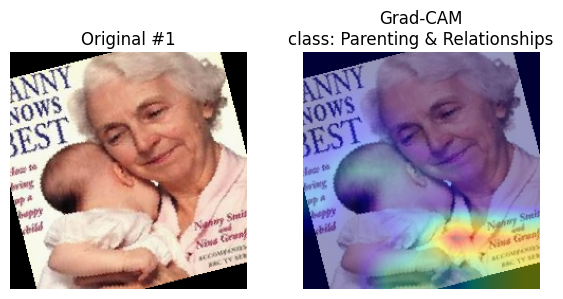


=== Example 2 (dataset index 1510) ===
Predicted class index: 24
Predicted class name: Science Fiction & Fantasy


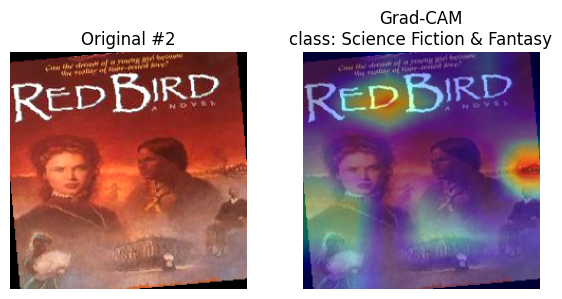


=== Example 3 (dataset index 9386) ===
Predicted class index: 3
Predicted class name: Calendars


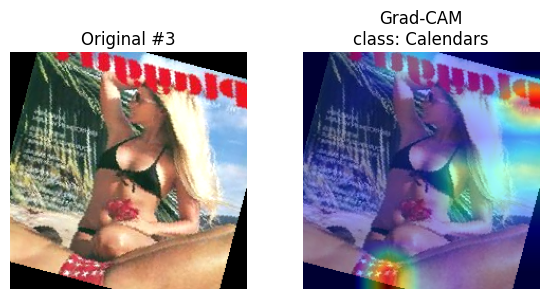


=== Example 4 (dataset index 4130) ===
Predicted class index: 11
Predicted class name: Health, Fitness & Dieting


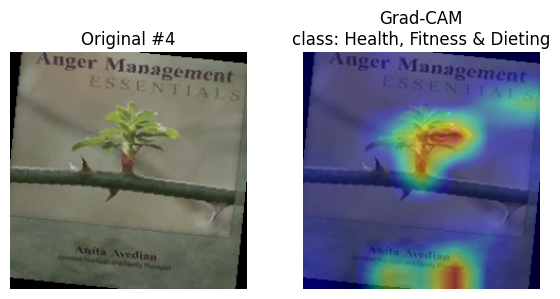


=== Example 5 (dataset index 3615) ===
Predicted class index: 29
Predicted class name: Travel


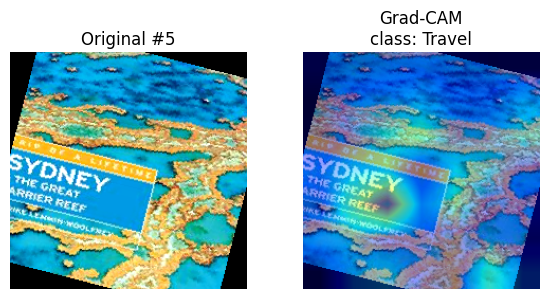

In [15]:
################## CELLA 9 – Grad-CAM (random multi-example) ##################
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import random

# ImageNet normalization (uguale a quella usata in data_transforms)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Inverse normalization per visualizzare le immagini
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(IMAGENET_MEAN, IMAGENET_STD)],
    std=[1.0 / s for s in IMAGENET_STD],
)

def generate_gradcam(model, input_tensor, target_class=None, target_layer_name="layer4"):
    """
    Calcola Grad-CAM per una singola immagine (C,H,W) già normalizzata (ImageNet).
    Ritorna (cam, target_class) dove cam è un array 2D numpy in [0,1].
    """
    model.eval()
    # [1, C, H, W]
    input_tensor = input_tensor.unsqueeze(0).to(device)

    activations = {}
    gradients = {}

    def fwd_hook(module, inp, out):
        activations["value"] = out.detach()

    def bwd_hook(module, grad_input, grad_output):
        # grad_output è una tupla; prendiamo il gradiente rispetto alle feature map in uscita
        gradients["value"] = grad_output[0].detach()

    # Per ResNet50, "layer4" è l’ultimo blocco convoluzionale
    target_layer = dict(model.named_modules())[target_layer_name]
    handle_fwd = target_layer.register_forward_hook(fwd_hook)

    # Compatibilità: prima proviamo full_backward_hook, altrimenti backward_hook
    if hasattr(target_layer, "register_full_backward_hook"):
        handle_bwd = target_layer.register_full_backward_hook(bwd_hook)
    else:
        handle_bwd = target_layer.register_backward_hook(bwd_hook)

    # Forward pass
    output = model(input_tensor)  # [1, num_classes]

    # Se non specificata, usiamo la classe predetta
    if target_class is None:
        target_class = int(output.argmax(dim=1).item())

    # Backward sullo score della classe scelta
    model.zero_grad()
    score = output[0, target_class]
    score.backward()

    # Rimuoviamo gli hook per non lasciarli attaccati al modello
    handle_fwd.remove()
    handle_bwd.remove()

    # Attivazioni e gradienti
    acts = activations["value"]   # [1, C, H', W']
    grads = gradients["value"]    # [1, C, H', W']

    # Global average pooling sui gradienti -> pesi per canale
    weights = grads.mean(dim=(2, 3), keepdim=True)  # [1, C, 1, 1]

    # Combinazione pesata delle attivazioni
    cam = (weights * acts).sum(dim=1, keepdim=True)  # [1, 1, H', W']
    cam = F.relu(cam)

    # Resize della CAM alla risoluzione dell’input
    cam = F.interpolate(
        cam,
        size=(input_tensor.size(2), input_tensor.size(3)),
        mode="bilinear",
        align_corners=False,
    )

    cam = cam.squeeze().cpu().numpy()  # [H, W]

    # Normalizzazione in [0,1] per la visualizzazione
    cam -= cam.min()
    if cam.max() > 0:
        cam /= cam.max()

    return cam, target_class

def show_gradcam_on_image(input_tensor, cam, pred_class_idx=None, example_idx=None):
    """
    input_tensor: tensore immagine singola (C,H,W), normalizzato.
    cam: array numpy 2D [H,W] in [0,1].
    """
    # Denormalizza per visualizzare
    x = inv_normalize(input_tensor.cpu()).clamp(0, 1)
    img = np.transpose(x.numpy(), (1, 2, 0))  # C,H,W -> H,W,C

    plt.figure(figsize=(6, 3))

    # Immagine originale
    plt.subplot(1, 2, 1)
    title_left = "Original"
    if example_idx is not None:
        title_left += f" #{example_idx}"
    plt.title(title_left)
    plt.imshow(img)
    plt.axis("off")

    # Immagine + heatmap
    plt.subplot(1, 2, 2)
    title = "Grad-CAM"
    if pred_class_idx is not None:
        try:
            title += f"\nclass: {train_dataset.classes[pred_class_idx]}"
        except Exception:
            title += f"\nclass idx: {pred_class_idx}"
    plt.title(title)
    plt.imshow(img)
    plt.imshow(cam, cmap="jet", alpha=0.4)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# ---- ESEMPIO: immagini random dal validation set ----

NUM_EXAMPLES = 5   # quante immagini mostrare
SEED = None        # metti un intero (es. 42) per rendere la scelta riproducibile

if SEED is not None:
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

val_dataset = val_loader.dataset       # può essere un Subset
num_val = len(val_dataset)
num_to_show = min(NUM_EXAMPLES, num_val)

# Scegliamo indici casuali dal validation set
indices = random.sample(range(num_val), num_to_show)

for example_idx, idx in enumerate(indices, start=1):
    sample_img, sample_label = val_dataset[idx]  # immagine già trasformata (resize + normalize)
    cam, pred_cls = generate_gradcam(trained_model, sample_img)

    print(f"\n=== Example {example_idx} (dataset index {idx}) ===")
    print("Predicted class index:", pred_cls)
    try:
        print("Predicted class name:", train_dataset.classes[pred_cls])
    except Exception:
        pass

    show_gradcam_on_image(
        sample_img,
        cam,
        pred_class_idx=pred_cls,
        example_idx=example_idx
    )
